# Face Recognition Real Life using Google Colab 

In [3]:
# make sure that we use GPU runtime
!nvidia-smi
!pip install face_recognition
# download the sample images 
!wget https://raw.githubusercontent.com/ageitgey/face_recognition/master/examples/two_people.jpg
!wget https://raw.githubusercontent.com/ageitgey/face_recognition/master/examples/obama.jpg
!wget https://raw.githubusercontent.com/ageitgey/face_recognition/master/examples/biden.jpg

Fri Sep 10 13:50:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os 
import PIL 
from IPython.display import display
import face_recognition
import numpy as np

In [8]:
from PIL import ImageDraw

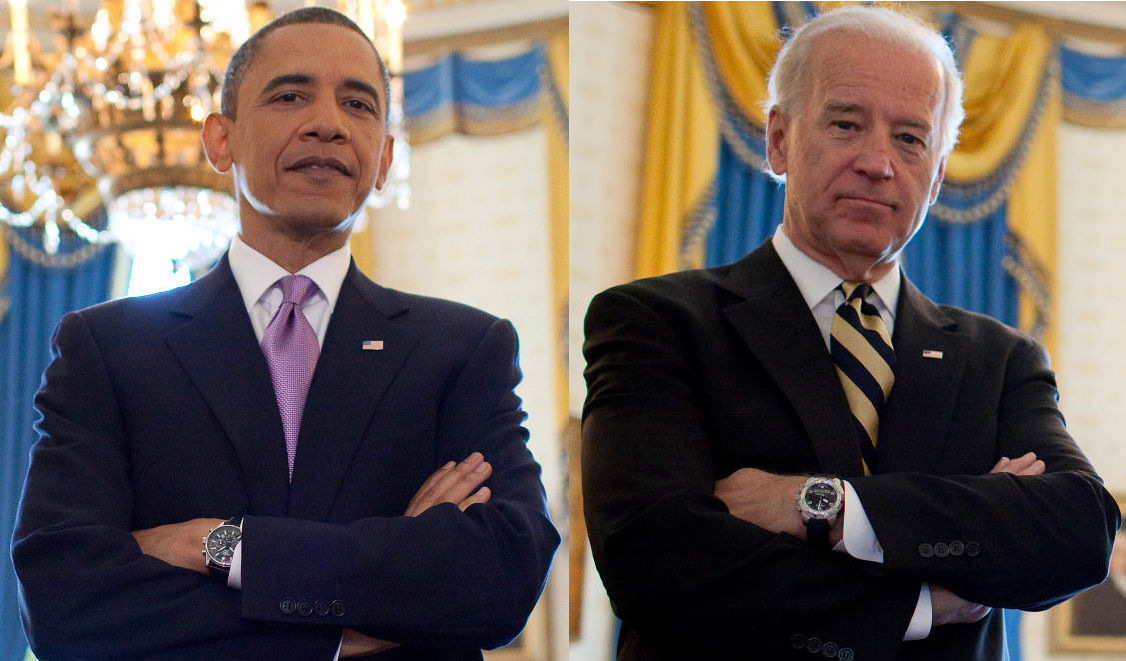

In [5]:
# The program we will be finding faces on the example below
pil_im = PIL.Image.open('./two_people.jpg')
display(pil_im)

# Load Sample Picture

In [6]:
# This is an example of running face recognition on a single image
# and drawing a box around each person that was identified.

# Load a sample picture and learn how to recognize it.
obama_image = face_recognition.load_image_file("./obama.jpg")
obama_face_encoding = face_recognition.face_encodings(obama_image)[0]

# Load a second sample picture and learn how to recognize it.
biden_image = face_recognition.load_image_file("./biden.jpg")
biden_face_encoding = face_recognition.face_encodings(biden_image)[0]

# Create arrays of known face encodings and their names
known_face_encodings = [
    obama_face_encoding,
    biden_face_encoding
]
known_face_names = [
    "Barack Obama",
    "Joe Biden"
]
print('Learned encoding for', len(known_face_encodings), 'images.')

Learned encoding for 2 images.


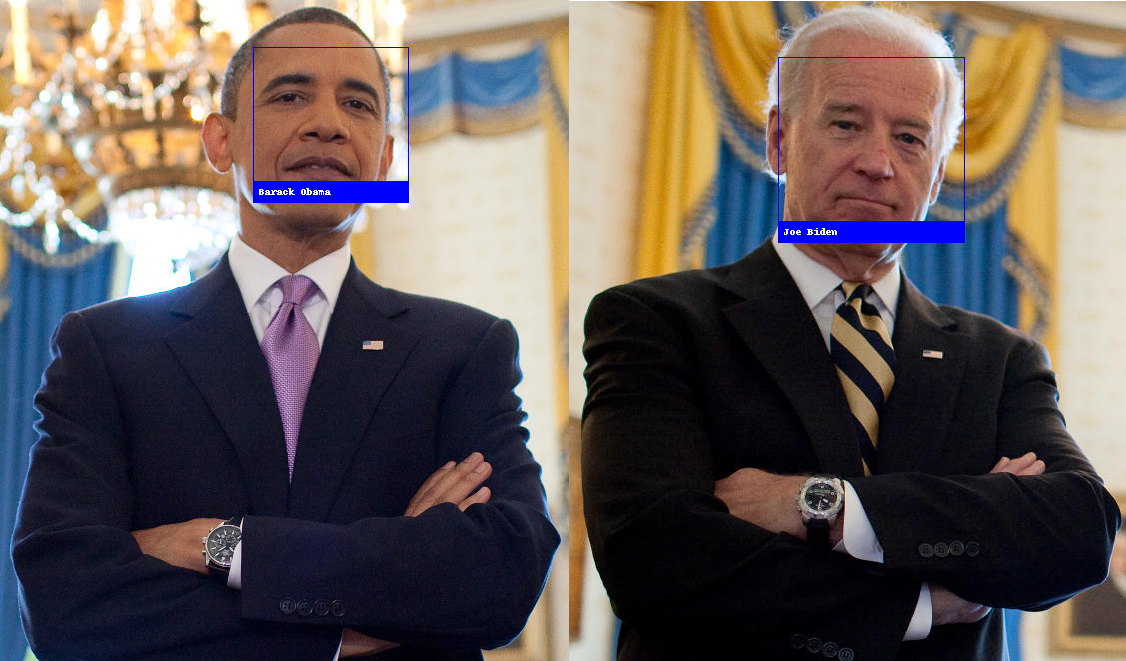

In [9]:
# Load an image with an unknown face
unknown_image = face_recognition.load_image_file("./two_people.jpg")
#print(unknown_image)
# Find all the faces and face encodings in the unknown image
face_locations = face_recognition.face_locations(unknown_image)
face_encodings = face_recognition.face_encodings(unknown_image, face_locations)

# Convert the image to a PIL-format image so that we can draw on top of it with the Pillow library
# See http://pillow.readthedocs.io/ for more about PIL/Pillow
pil_image = PIL.Image.fromarray(unknown_image)
# Create a Pillow ImageDraw Draw instance to draw with
draw = ImageDraw.Draw(pil_image)

# Loop through each face found in the unknown image
for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
    # See if the face is a match for the known face(s)
    matches = face_recognition.compare_faces(known_face_encodings, face_encoding)

    name = "Unknown"

    # Or instead, use the known face with the smallest distance to the new face
    face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
    best_match_index = np.argmin(face_distances)
    if matches[best_match_index]:
        name = known_face_names[best_match_index]

    # Draw a box around the face using the Pillow module
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

    # Draw a label with a name below the face
    text_width, text_height = draw.textsize(name)
    draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
    draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))


# Remove the drawing library from memory as per the Pillow docs
del draw

# Display the resulting image
display(pil_image)

In [10]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [11]:
#@title function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [12]:
#@title JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Take a photo of you 

In [13]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  

  cv2.imwrite(filename, img)

  return filename

## Trying to use my face here (this is a cruical step to add your face, so don't skip it) 

<IPython.core.display.Javascript object>

Saved to photo.jpg


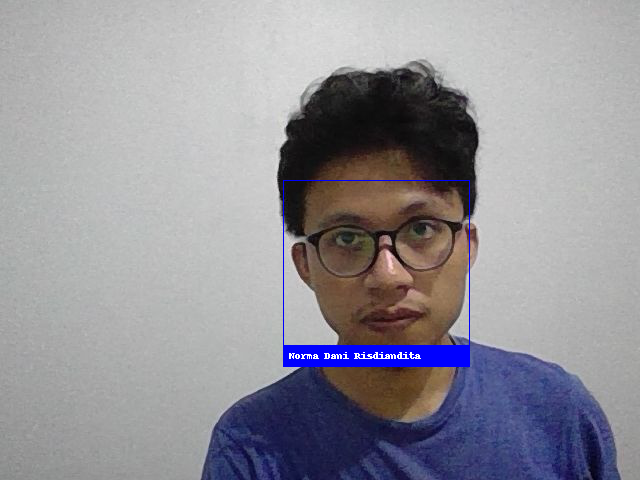

In [14]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # input the face image to face recognition 
  
  dani_image = face_recognition.load_image_file("./photo.jpg")
  dani_face_encoding = face_recognition.face_encodings(dani_image)[0]

  #adding my face to the encoding (put your name here)
  known_face_encodings.append(dani_face_encoding)
  known_face_names.append("Dani")

  # draw boxes on my photo 
  face_locations = face_recognition.face_locations(dani_image)
  face_encodings = face_recognition.face_encodings(dani_image, face_locations)

  pil_image = PIL.Image.fromarray(dani_image)
  # Create a Pillow ImageDraw Draw instance to draw with
  draw = PIL.ImageDraw.Draw(pil_image)

    # Loop through each face found in the unknown image
  for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
      # See if the face is a match for the known face(s)
      matches = face_recognition.compare_faces(known_face_encodings, face_encoding)

      name = "Unknown"

      # Or instead, use the known face with the smallest distance to the new face
      face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
      best_match_index = np.argmin(face_distances)
      if matches[best_match_index]:
          name = known_face_names[best_match_index]

      # Draw a box around the face using the Pillow module
      draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

      # Draw a label with a name below the face
      text_width, text_height = draw.textsize(name)
      draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
      draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))

  del draw 
  display(pil_image)
  # Show the image which was just taken.
  # display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Opening your Webcam and your face is labeled 

In [15]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # Find all the faces and face encodings in the unknown image
    face_locations = face_recognition.face_locations(img)
    face_encodings = face_recognition.face_encodings(img, face_locations)
    #print(face_locations)
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Loop through each face found in the unknown image
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
        # See if the face is a match for the known face(s)
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)

        name = "Unknown"

        # Or instead, use the known face with the smallest distance to the new face
        face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = known_face_names[best_match_index]

        # Draw a box around the face using the Pillow module
        #draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

        bbox_array = cv2.rectangle(bbox_array,(left,top),(right,bottom),(0,0,255),2)
        (text_width, text_height), baseline = cv2.getTextSize(name,
                                                              cv2.FONT_HERSHEY_SIMPLEX,
                                                              0.75, 1)
        bbox_array = cv2.rectangle(bbox_array, (left, bottom - text_height - 10), (right, bottom), (0, 0, 255), -1)
        bbox_array = cv2.putText(bbox_array, name,
                        (left+6, bottom - text_height + 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color=(255,255,255), thickness=2)

        bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
        # convert overlay of bbox into bytes
        bbox_bytes = bbox_to_bytes(bbox_array)
        # update bbox so next frame gets new overlay
        bbox = bbox_bytes

<IPython.core.display.Javascript object>